# Python: Group Average Treatment Effects (GATEs) for IRM models

In this simple example, we illustrate how the [DoubleML](https://docs.doubleml.org/stable/index.html) package can be used to estimate group average treatment effects in the [DoubleMLIRM](https://docs.doubleml.org/stable/guide/models.html#interactive-regression-model-irm) model.

## Data

The data will be generated with a simple data generating process to enable us to know the true group effects.

In [1]:
import numpy as np
import pandas as pd
import doubleml as dml

Here, we consider three different groups which depend on the first covariate, which could correspond to e.g. three different age groups in the sample.
For simplicity, the treatment effect within each group is generated to be constant, such that it corresponds to the group average treatment effect.

In [2]:
def group_effect(x):
    if x[0] <= -0.7:
        te = 3
    elif (x[0] > -0.7) & (x[0] <= 0.2):
        te = 1
    else:
        te = 0
    return te

The data is generated as

$$
\begin{aligned}
Y_i & = g(W_1)T_i + \langle W_i,\gamma_0\rangle + \epsilon_i \\
T_i & = \langle W_i,\beta_0\rangle +\eta_i,
\end{aligned}
$$

where $W_i\sim\mathcal{N}(0,I_{d_w})$ and $\epsilon_i,\eta_i\sim\mathcal{U}[0,1]$.
The coefficient vectors $\gamma_0$ and $\beta_0$ both have small random support which values are drawn independently from $\mathcal{U}[0,1]$.
Further, $g(w_1)$ defines the conditional treatment effect, which is generated depending on $w_1$.

$$g(w_1) = \begin{cases}3\quad,\text{for } w_1\le -0.7\\
1\quad,\text{for } -0.7 < w_1\le  0.2\\
0\quad,\text{for } 0.2 < w_1\\
 \end{cases}.$$

In [3]:
def create_synthetic_group_data(n_samples=200, n_w=10, support_size=5):
    """
    Creates a simple synthetic example for group effects.

    Parameters
    ----------
    n_samples : int
        Number of samples.
        Default is ``200``.

    n_w : int
        Dimension of covariates.
        Default is ``10``.

    support_size : int
        Number of relevant covariates.
        Default is ``5``.

    Returns
    -------
     data : pd.DataFrame
            A data frame.

    """
    # Outcome support
    support_w = np.random.choice(np.arange(n_w), size=support_size, replace=False)
    coefs_w = np.random.uniform(0, 1, size=support_size)
    # Define the function to generate the noise
    epsilon_sample = lambda n: np.random.uniform(-1, 1, size=n_samples)
    # Treatment support
    # Assuming the matrices gamma and beta have the same number of non-zero components
    support_t = np.random.choice(np.arange(n_w), size=support_size, replace=False)
    coefs_t = np.random.uniform(0, 1, size=support_size)
    # Define the function to generate the noise
    eta_sample = lambda n: np.random.uniform(-1, 1, size=n_samples)

    # Generate controls, covariates, treatments and outcomes
    w = np.random.normal(0, 1, size=(n_samples, n_w))
    # Group treatment effect
    te = np.apply_along_axis(group_effect, axis=1, arr=w)
    # Define treatment
    log_odds = np.dot(w[:, support_t], coefs_t) + eta_sample(n_samples)
    t_sigmoid = 1 / (1 + np.exp(-log_odds))
    t = np.array([np.random.binomial(1, p) for p in t_sigmoid])
    # Define the outcome
    y = te * t + np.dot(w[:, support_w], coefs_w) + epsilon_sample(n_samples)

    # Now we build the dataset
    y_df = pd.DataFrame({'y': y})
    t_df = pd.DataFrame({'t': t})
    w_df = pd.DataFrame(data=w, index=np.arange(w.shape[0]), columns=[f'w_{i}' for i in range(w.shape[1])])

    data = pd.concat([y_df, t_df, w_df], axis=1)
    covariates = list(w_df.columns.values)

    return data, covariates

We will consider a quite small number of covariates to ensure fast calcualtion.

In [4]:
# DGP constants
np.random.seed(42)
n_samples = 500
n_w = 10
support_size = 5

# Create data
data, covariates = create_synthetic_group_data(n_samples=n_samples, n_w=n_w, support_size=support_size)
data_dml_base = dml.DoubleMLData(data,
                                 y_col='y',
                                 d_cols='t',
                                 x_cols=covariates)

## Interactive Regression Model (IRM)
The first step is to fit a [DoubleML IRM Model](https://docs.doubleml.org/stable/guide/models.html#interactive-regression-model-irm) to the data.

In [5]:
# First stage estimation
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
randomForest_reg = RandomForestRegressor(n_estimators=500)
randomForest_class = RandomForestClassifier(n_estimators=500)

np.random.seed(42)

dml_irm = dml.DoubleMLIRM(data_dml_base,
                          ml_g=randomForest_reg,
                          ml_m=randomForest_class,
                          trimming_threshold=0.01,
                          n_folds=5)
print("Training IRM Model")
dml_irm.fit(store_predictions=True)

Training IRM Model


## Group Average Treatment Effects (GATEs)
Next, we can specify the groups as [DataFrame](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html) with boolean columns.

In [6]:
groups = pd.DataFrame(np.column_stack([data['w_0'] <= -0.7,
                                       (data['w_0'] > -0.7) & (data['w_0'] <= 0.2),
                                       data['w_0'] > 0.2]),
             columns=['Group 1', 'Group 2', 'Group 3'])

In [7]:
print(groups.head())

   Group 1  Group 2  Group 3
0    False     True    False
1    False     True    False
2     True    False    False
3     True    False    False
4     True    False    False


To calculate GATEs just call the ``gate()`` method and supply the DataFrame with the group definitions and the ``level`` (with default of ``0.95``).

In [8]:
gate = dml_irm.gate(groups=groups)
print(gate.confint(level=0.95))

            2.5 %    effect    97.5 %
Group 1  2.793648  3.125180  3.456711
Group 2  0.935750  1.233350  1.530950
Group 3 -0.170841  0.024572  0.219985


The confidence intervals above are point-wise, but by setting the option ``joint`` and providing a number of bootstrap repetitions ``n_rep_boot``.

In [9]:
ci = gate.confint(level=0.95, joint=True, n_rep_boot=1000)
print(ci)

            2.5 %    effect    97.5 %
Group 1  2.498694  3.125180  3.751665
Group 2  0.670983  1.233350  1.795717
Group 3 -0.344695  0.024572  0.393839


Finally, let us plot the estimates together with the true effect within each group.

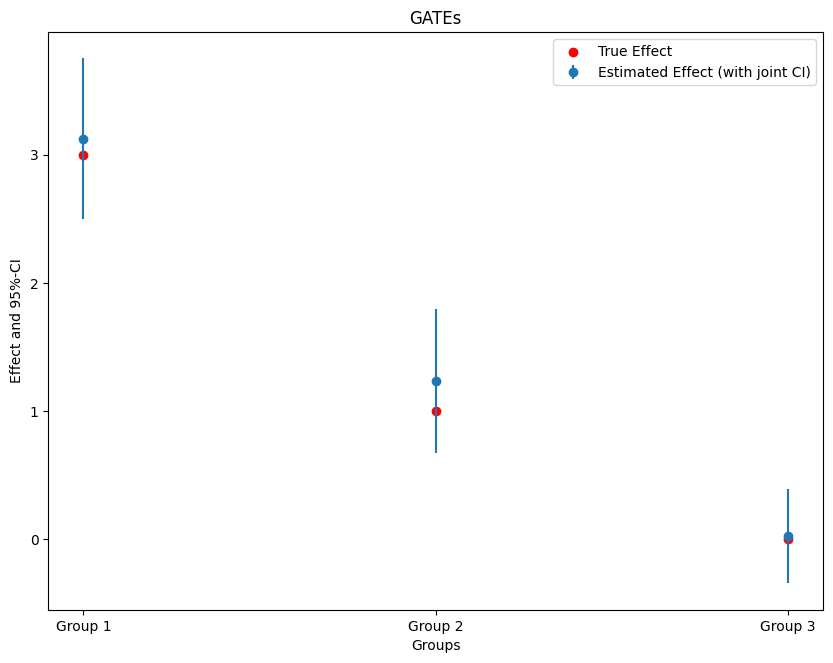

In [10]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 10., 7.5

errors = np.full((2, ci.shape[0]), np.nan)
errors[0, :] = ci['effect'] - ci['2.5 %']
errors[1, :] = ci['97.5 %'] - ci['effect']

plt.errorbar(ci.index, ci.effect, fmt='o', yerr=errors, label='Estimated Effect (with joint CI)')

#add true effect
ax = plt.subplot(1, 1, 1)
ax.scatter(x=['Group 1', 'Group 2', 'Group 3'], y=[3, 1, 0], c='red', label='True Effect')

plt.title('GATEs')
plt.xlabel('Groups')
plt.legend()
_ = plt.ylabel('Effect and 95%-CI')

It is also possible to supply disjoint groups as a single vector (still as a data frame). Remark the slightly different name.

In [11]:
groups =  pd.DataFrame(columns=['Group'], index=range(data['w_0'].shape[0]), dtype=str)
for i, w_i in enumerate(data['w_0']):
    if w_i <= -0.7:
         groups['Group'][i] = '1'
    elif (w_i > -0.7) & (w_i <= 0.2):
         groups['Group'][i] = '2'
    else:
         groups['Group'][i] = '3'

print(groups.head())

  Group
0     2
1     2
2     1
3     1
4     1


In [12]:
gate = dml_irm.gate(groups=groups)
ci = gate.confint()
print(ci)

            2.5 %    effect    97.5 %
Group_1  2.793648  3.125180  3.456711
Group_2  0.935750  1.233350  1.530950
Group_3 -0.170841  0.024572  0.219985


The coefficients of the best linear predictor can be seen via the summary (the values can be accessed through the underlying model ``.blp_model``).

In [13]:
print(gate.summary)

             coef   std err          t         P>|t|    [0.025    0.975]
Group_1  3.125180  0.149762  20.867623  6.450889e-70  2.830935  3.419425
Group_2  1.233350  0.142024   8.684105  5.517504e-17  0.954309  1.512391
Group_3  0.024572  0.117686   0.208795  8.346940e-01 -0.206651  0.255795


Remark that the confidence intervals are slightly smaller, since they are not based on the White's heteroskedasticity robus standard errors.

In [14]:
print(gate)

================== DoubleMLBLP Object ==================

------------------ Fit summary ------------------
             coef   std err          t         P>|t|    [0.025    0.975]
Group_1  3.125180  0.149762  20.867623  6.450889e-70  2.830935  3.419425
Group_2  1.233350  0.142024   8.684105  5.517504e-17  0.954309  1.512391
Group_3  0.024572  0.117686   0.208795  8.346940e-01 -0.206651  0.255795


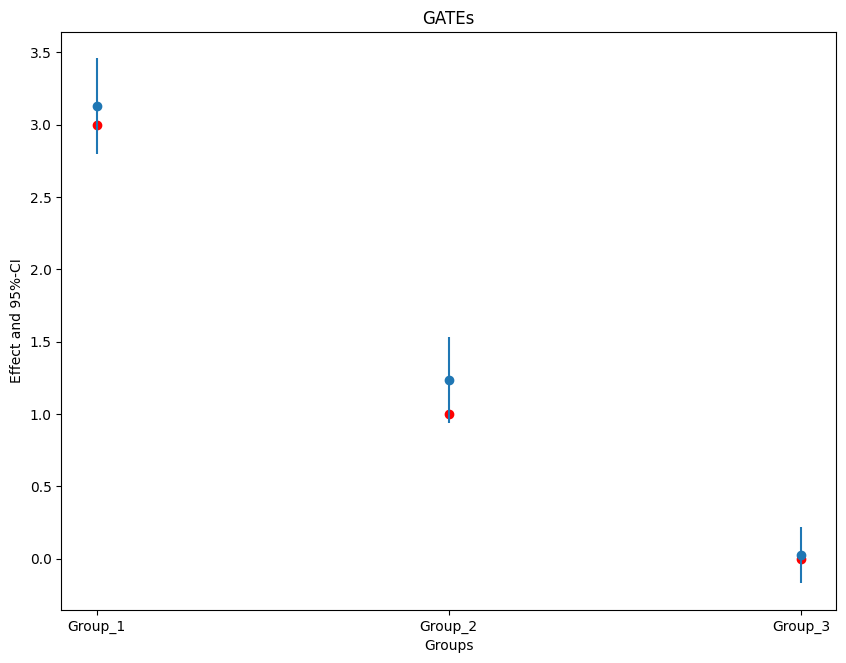

In [15]:
errors = np.full((2, ci.shape[0]), np.nan)
errors[0, :] = ci['effect'] - ci['2.5 %']
errors[1, :] = ci['97.5 %'] - ci['effect']

#add true effect
ax = plt.subplot(1, 1, 1)
ax.scatter(x=['Group_1', 'Group_2', 'Group_3'], y=[3, 1, 0], c='red', label='True Effect')

plt.errorbar(ci.index, ci.effect, fmt='o', yerr=errors)
plt.title('GATEs')
plt.xlabel('Groups')
_ =  plt.ylabel('Effect and 95%-CI')